---
用spline来做ZIP,2018.1.11,数据变为半年一周期
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from Plot_raw import *

# ipcluster nbextension enable

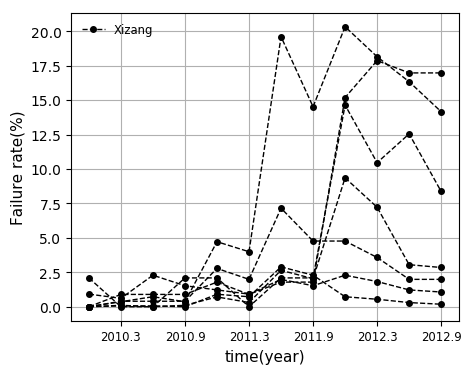

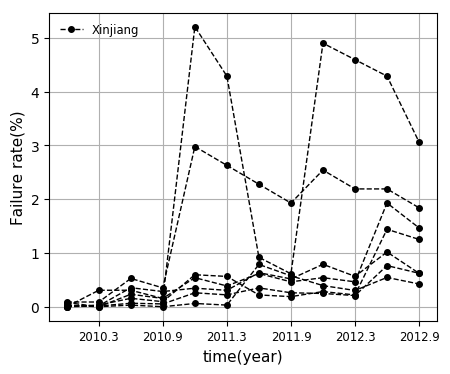

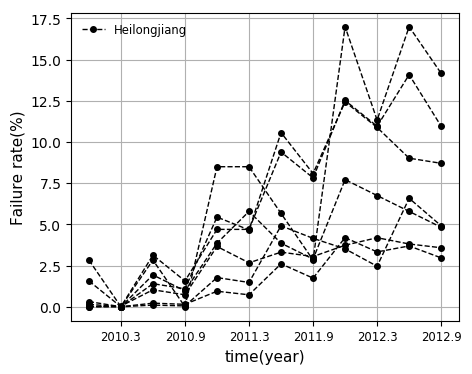

In [117]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZmulti_12.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values
# print(companyABC)
# print(companiesABC)
# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 3])

# #特征因素分析
elec_tem = elec_data.Tem.values # 观测温度值x2，温度不加噪声
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 0]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 1] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 2] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# elec_Pca2 = np.vstack((elec_tem, elec_hPa, elec_RH, elec_Lux)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
print('\n')

# elec_data.Fault.values[48] =2000
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 1000 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)


# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*12:(i+1)*12] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*12:(i+1)*12] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(21)])

Plot_raw(elec_year2, elec_faults2, Savefig)
# 共享变量设置
# xs_char1 = shared(np.asarray(elec_Pca_char1))
# xs_char2 = shared(np.asarray(elec_Pca_char2))

# ys_faults = shared(np.asarray(elec_faults))
# xs_year = shared(np.asarray(data_cs_year))
# Num_shared = shared(np.asarray(companyABC))

def logit(x):
    return 1/(1+np.exp(-x))
def Invlogit(x):
    return tt.exp(x)/(1+tt.exp(x))

In [132]:
# 建模，模型
# import ipyparallel as ipp
with pm.Model() as model_1:
    # define priors
#     mu_2 = pm.Normal('mu_2', mu=0, sd=100)
#     sd_2 = pm.HalfCauchy('sd_2', 10)
#     mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
#     sd_1 = pm.HalfCauchy('sd_1', 10)
    mu_0 = pm.Normal('mu_0', mu=0, sd=100)
    sd_0 = pm.HalfCauchy('sd_0', 10)
    
#     beta2 = pm.Normal('beta2', mu_2, sd_2)
    beta1 = pm.GaussianRandomWalk('beta1', sd=10, shape=companiesABC)
    beta = pm.Normal('beta', mu_0, sd_0, shape=companiesABC)

    amu_1 = pm.Normal('amu_1', mu=0, sd=100)
    asd_1 = pm.HalfCauchy('asd_1', 10)
    amu_0 = pm.Normal('amu_0', mu=0, sd=100)
    asd_0 = pm.HalfCauchy('asd_0', 10)
    
    alpha1 = pm.Normal('alpha1', amu_1, asd_1)
    alpha = pm.Normal('alpha', amu_0, asd_0)
    
    psi = pm.Deterministic('psi', Invlogit(alpha + alpha1*elec_year))
    theta = pm.Deterministic('theta', tt.exp(beta[companyABC] + beta1[companyABC] * elec_year))
    
#     aa = pm.Gamma('aa', alpha=1, beta=0.5)alpha=aa, 
    Observed = pm.ZeroInflatedPoisson('Observed', psi =psi, theta =theta, observed=elec_faults)  # 观测值
    trace_1 = pm.sample(3000, njobs=1)
#     ,  init='advi+adapt_diag'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████████████████████████████████████████████▉| 3498/3500 [01:09<00:00, 50.02it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.7115096557, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 420 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [01:09<00:00, 50.02it/s]


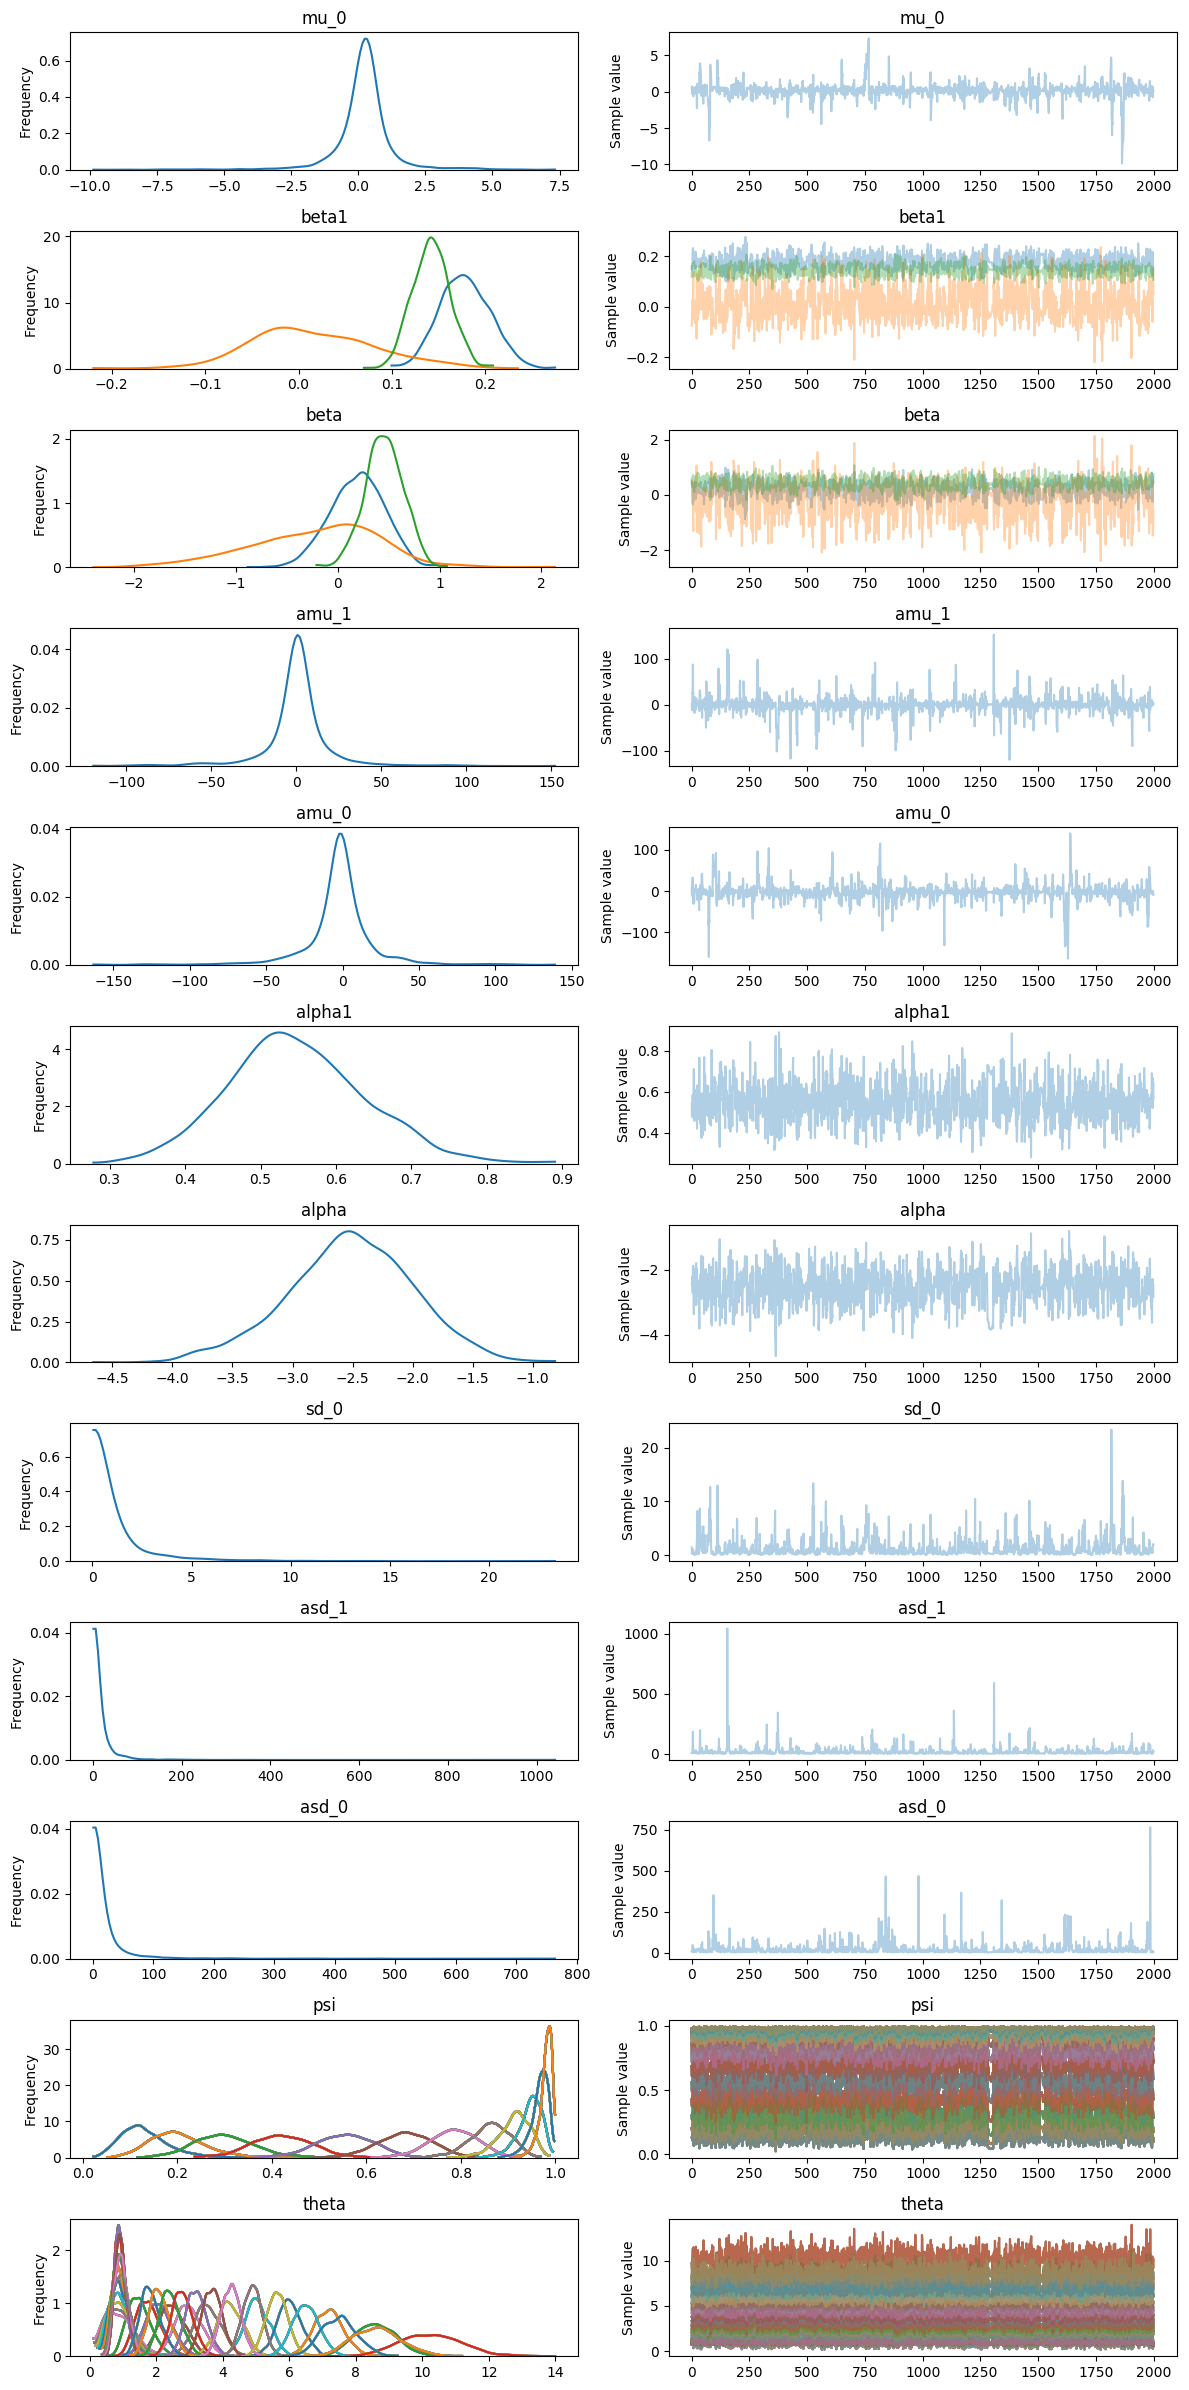

In [125]:
chain = trace_1[1000:]
pm.traceplot(chain)
plt.show()

In [131]:
varnames2 = ['beta', 'beta1']
tmp = pm.df_summary(chain, varnames2)
betaMAP = tmp['mean'][np.arange(companiesABC)]
beta1MAP = tmp['mean'][np.arange(companiesABC) + 1*companiesABC]
# beta2MAP = tmp['mean'][1*companiesABC+1]
# beta3MAP = tmp['mean'][np.arange(companiesABC) + 2*companiesABC+1]
# beta4MAP = tmp['mean'][np.arange(companiesABC) + 4*companiesABC]
# uMAP = tmp['mean'][3*companiesABC+1]
print(tmp)

varnames1 = ['alpha', 'alpha1']
tmp0 = pm.df_summary(chain, varnames1)
alphaMAP = tmp0['mean'][0]
alpha1MAP = tmp0['mean'][1]
print(tmp0)

              mean        sd  mc_error   hpd_2.5  hpd_97.5
beta__0   0.191787  0.262924  0.010017 -0.334682  0.665732
beta__1  -0.228978  0.626200  0.024675 -1.558118  0.846676
beta__2   0.451802  0.187264  0.006603  0.092181  0.817869
beta1__0  0.177788  0.026873  0.001000  0.127705  0.229673
beta1__1  0.015051  0.065762  0.002565 -0.097503  0.155839
beta1__2  0.141709  0.020051  0.000705  0.106110  0.183055
            mean        sd  mc_error   hpd_2.5  hpd_97.5
alpha  -2.519649  0.518992  0.021153 -3.498390 -1.450203
alpha1  0.548136  0.090772  0.003400  0.370406  0.716761


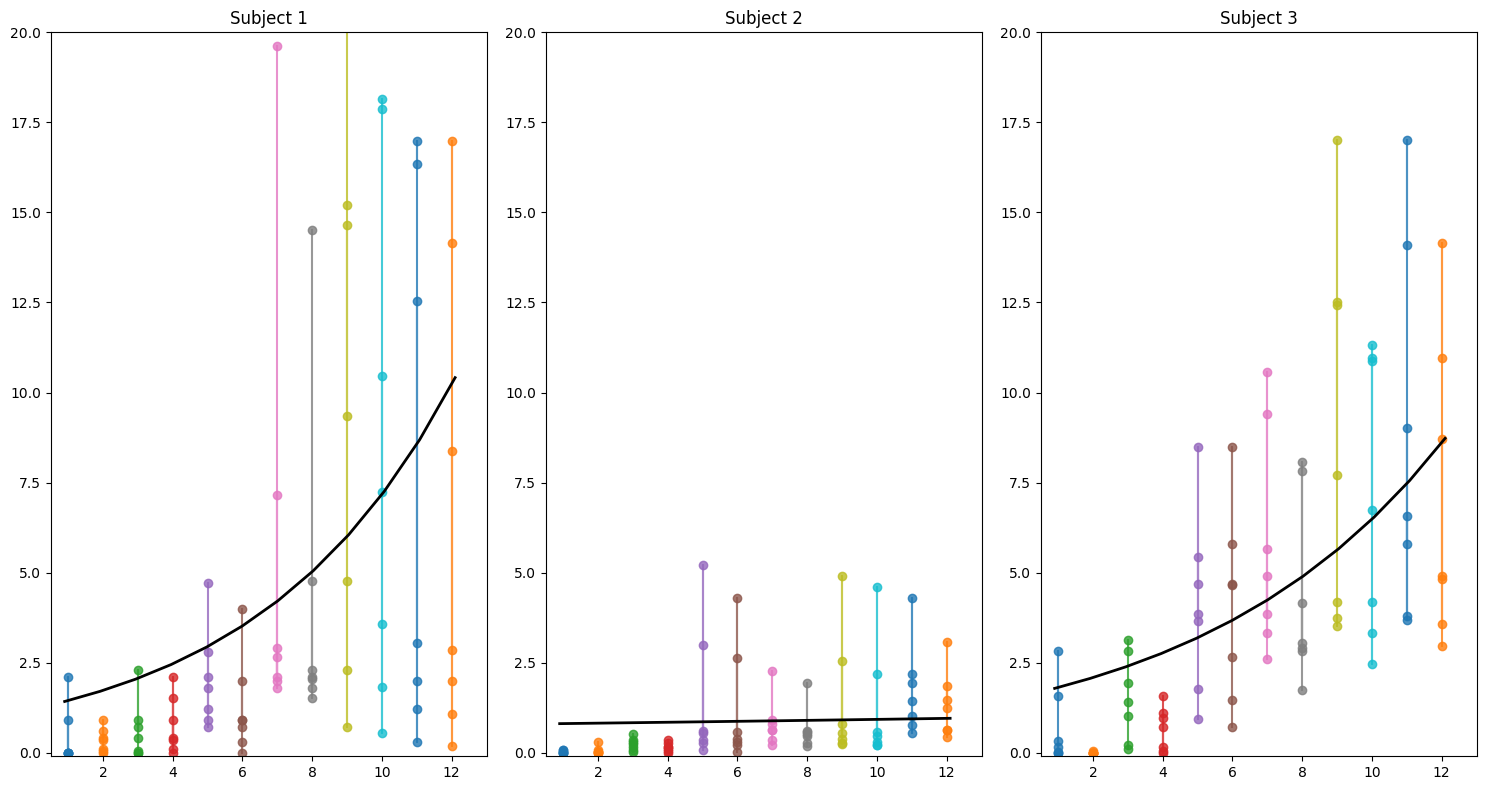

[-2. -1. -1. -0.  0.  1.  1.  2.  2.  3.  4.  4.]
[ 0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.]


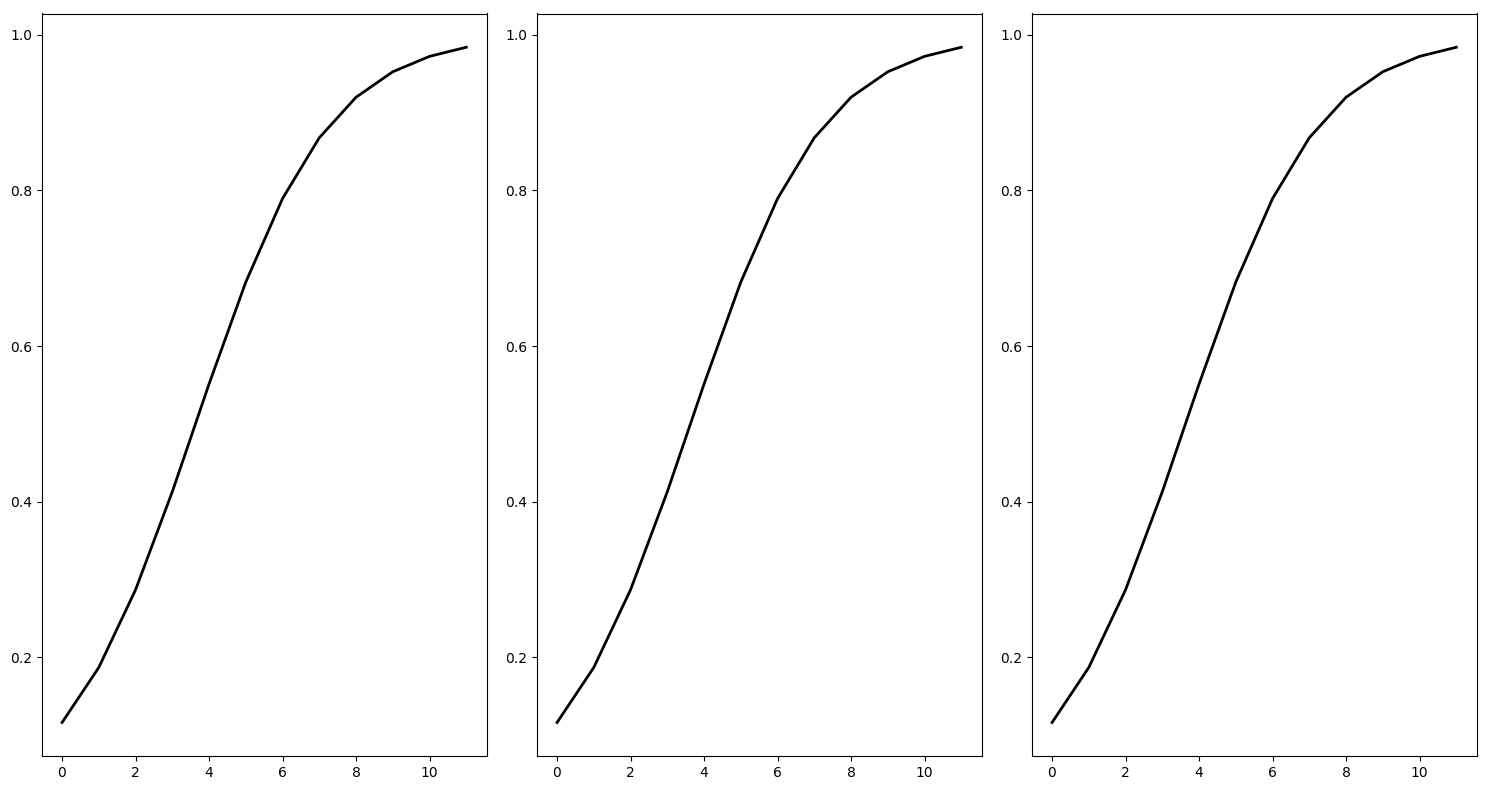

In [129]:
from matplotlib import gridspec
plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 3)
for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    
    xl = np.linspace(0.9, 12.1, 12)
    yl = np.exp(betaMAP[ip] + beta1MAP[ip]*xl )
#     + beta2MAP*elec_tem1[ip*84:(ip*84+12)]
    ax.plot(xp, yp, marker='o', alpha=.8)
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xl, yl, 'k', linewidth=2)
    plt.axis([0.5, 13, -.1, 20])
    plt.title('Subject %s' % (ip + 1))
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 3)
for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    y0 = alphaMAP + alpha1MAP*xl
    y00 = np.exp(y0)/(1+np.exp(y0))
    x0 = np.linspace(0.9, 12.1, 12)
    ax.plot(y00, 'k', linewidth=2)
print(y0)
print(y00)
plt.tight_layout()
plt.show()

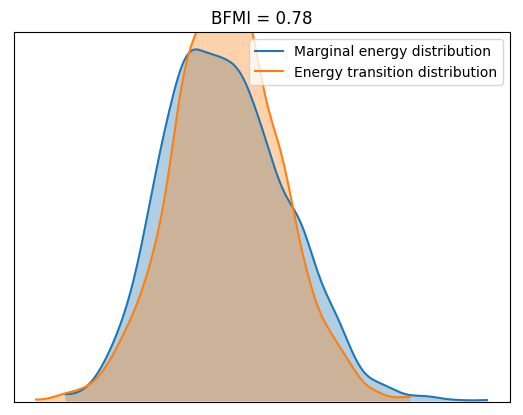

In [130]:
# energy = trace_1['energy']
# energy_diff = np.diff(energy)
# sns.distplot(energy - energy.mean(), label='energy')
# sns.distplot(energy_diff, label='energy diff')
# plt.legend()
# plt.show()
ax = pm.energyplot(trace_1)
bfmi = pm.bfmi(trace_1)
ax.set_title(f"BFMI = {bfmi:.2f}");
plt.show()


In [81]:
# The Gelman-Rubin statistics indicate that the chains have converged
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_1).values())

ValueError: Gelman-Rubin diagnostic requires multiple chains of the same length.

In [ ]:
# pm.gelman_rubin(trace_1)